# Load packages

In [1]:
!pwd

/storage/users/job37yv/Projects/Franziska_faber/scripts/notebooks


# Read data

In [15]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

# -------- settings / helpers --------
FILENAME_REGEX = r'^(?P<condition>Co_colonized|C_diff|B_theta|mock)_(?P<tissue>[A-Za-z]+)_(?P<replicate>bio\d+)_host_counts\.txt$'
COND_MAP = {"mock":"Mock", "B_theta":"Bt", "C_diff":"Cd", "Co_colonized":"Co"}

def list_featurecounts_files(count_dir: Path):
    return sorted([p for p in count_dir.glob("*_host_counts.txt") if p.is_file()])

def parse_meta(name: str):
    m = re.match(FILENAME_REGEX, name)
    if not m:
        raise ValueError(f"Filename does not match expected pattern: {name}")
    d = m.groupdict()
    d["sample"] = name.replace("_host_counts.txt","")
    d["condition"] = COND_MAP.get(d["condition"], d["condition"])
    return d

def read_featurecounts_series(path: Path):
    """
    Return (counts_series, length_series_or_None) indexed by Geneid.
    Keeps decimals (fractional counts).
    """
    df = pd.read_csv(path, sep="\t", comment="#")
    if "Geneid" not in df.columns:
        raise ValueError(f"Missing 'Geneid' in {path}")
    gene = df["Geneid"].astype(str)
    count_col = df.columns[-1]  # sample counts column
    s_counts = pd.to_numeric(df[count_col], errors="coerce").fillna(0.0)
    s_counts.index = gene
    s_len = None
    if "Length" in df.columns:
        s_len = pd.to_numeric(df["Length"], errors="coerce")
        s_len.index = gene
    return s_counts, s_len

def build_union_counts_and_length(files):
    """
    Concatenate all sample count series by index=Geneid (union join).
    For Length, keep the first non-null value encountered per gene.
    """
    count_frames = []
    length_master = pd.Series(dtype="float64")

    for p in files:
        s_counts, s_len = read_featurecounts_series(p)
        count_frames.append(s_counts.rename(p.name.replace("_host_counts.txt","")))
        if s_len is not None:
            # coalesce: keep existing length, fill new where missing
            length_master = length_master.combine_first(s_len)

    # samples x genes via concat along columns, union of indices
    X = pd.concat(count_frames, axis=1)  # index: Geneid (union), columns: samples
    X = X.fillna(0.0)

    # if any duplicate Geneid existed in a file (rare), groupby to be safe
    if not X.index.is_unique:
        X = X.groupby(level=0).sum()

    # tidy var table
    var = pd.DataFrame(index=X.index)
    if len(length_master) > 0:
        # only keep lengths for genes we have
        var["Length"] = length_master.reindex(X.index)
    return X.T, var  # return samples x genes, and var (genes x metadata)

def median_of_ratios_size_factors(counts: pd.DataFrame) -> pd.Series:
    """
    counts: samples x genes (float or int)
    Returns size factors per sample (index = samples).
    """
    # work gene-wise → samples-wise, so transpose for the usual formula
    GxS = counts.T  # genes x samples
    with np.errstate(divide='ignore', invalid='ignore'):
        logX = np.log(GxS.values)
    logX[np.isneginf(logX)] = np.nan
    gmeans = np.nanmean(logX, axis=1)
    gmeans = np.exp(gmeans)
    gmeans[gmeans == 0] = np.nan
    ratios = GxS.div(gmeans, axis=0)
    sf = ratios.median(axis=0, skipna=True)  # per sample
    sf = sf.replace([np.inf, -np.inf], np.nan).fillna(1.0)
    sf[sf == 0] = 1.0
    sf.index = GxS.columns
    return sf

def build_adata(root: Path):
    count_dir = root / "data" / "processed_data" / "Count_tables_all_groups"
    files = list_featurecounts_files(count_dir)
    print(f"Found {len(files)} count files in {count_dir}")
    if not files:
        raise SystemExit("No *_host_counts.txt files found.")

    # counts (samples x genes) with union of all genes; var (genes x meta)
    X, var = build_union_counts_and_length(files)

    # metadata (obs)
    obs_rows = [parse_meta(p.name) for p in files]
    obs = pd.DataFrame(obs_rows).set_index("sample").sort_index()
    # align rows: ensure same sample order
    X = X.loc[obs.index]

    # basic filter (optional but stabilizes size factors): keep genes seen in >=1 sample at >=1 count
    keep = (X >= 1).sum(axis=0) >= 1
    counts_filt = X.loc[:, keep]

    # size-factor normalization (DESeq-style) for exploration
    sfs = median_of_ratios_size_factors(counts_filt)
    norm = X.div(sfs, axis=0)
    log1p = np.log1p(norm)

    # Build AnnData if available; else return dict of tables
    try:
        import anndata as ad
        adata = ad.AnnData(X=X.values.astype(float))
        adata.obs = obs.copy()
        adata.var = var.loc[X.columns].copy()
        adata.layers["counts"] = X.values.astype(float)
        adata.layers["norm"]   = norm.values.astype(float)
        adata.layers["log1p"]  = log1p.values.astype(float)
        adata.uns["counts_type"] = "featureCounts fractional (-M --fraction)"
        adata.uns["notes"] = "Union of genes across samples; missing filled as 0. layers: counts/norm/log1p."
        print(adata)
        return adata
    except ImportError:
        print("[WARN] anndata not installed; returning tables instead.")
        return {"X": X, "obs": obs, "var": var, "norm": norm, "log1p": log1p}


In [16]:
from pathlib import Path
root = Path("/storage/users/job37yv/Projects/Franziska_faber")
adata = build_adata(root)

Found 12 count files in /storage/users/job37yv/Projects/Franziska_faber/data/processed_data/Count_tables_all_groups


/tmp/ipykernel_895724/2552363373.py:53: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  length_master = length_master.combine_first(s_len)


AnnData object with n_obs × n_vars = 12 × 67665
    obs: 'condition', 'tissue', 'replicate'
    var: 'Length'
    uns: 'counts_type', 'notes'
    layers: 'counts', 'norm', 'log1p'


# QC: Explore and refine data

## Quick overview and QC stats

In [17]:
import numpy as np
import pandas as pd

A = adata  # shorthand

# --- core shape / meta ---
n_samples, n_genes = A.n_obs, A.n_vars
conds = A.obs['condition'].value_counts().sort_index()
tissues = A.obs['tissue'].value_counts().sort_index() if 'tissue' in A.obs else pd.Series([], dtype=int)

print(f"samples: {n_samples} | genes: {n_genes}")
print("\nSamples per condition:")
display(conds)
print("\nSamples per tissue:")
display(tissues)

# --- missingness (should be none; zeros are expected) ---
def na_summary(layer_name):
    M = A.layers[layer_name] if layer_name in A.layers else A.X
    M = np.asarray(M)
    na = np.isnan(M).sum()
    return layer_name, na, na / M.size * 100

for L in ['counts','norm','log1p']:
    if L in A.layers:
        layer, n_na, pct_na = na_summary(L)
        print(f"{layer}: NAs={n_na} ({pct_na:.6f}%)")

# var metadata missingness (Length)
if 'Length' in A.var.columns:
    n_na_len = A.var['Length'].isna().sum()
    print(f"var['Length']: NAs={n_na_len} of {len(A.var)} genes ({n_na_len/len(A.var)*100:.2f}%)")

# --- sparsity (percent zeros per layer) ---
def zero_pct(M):
    M = np.asarray(M)
    return (M==0).sum()/M.size*100

for L in ['counts','norm','log1p']:
    if L in A.layers:
        print(f"{L} zeros: {zero_pct(A.layers[L]):.2f}%")

# --- per-sample QC ---
import pandas as pd
counts = np.asarray(A.layers['counts'])
libsize = counts.sum(axis=1)
genes_detected_1 = (counts >= 1).sum(axis=1)
genes_detected_0 = (counts > 0).sum(axis=1)

qc = pd.DataFrame({
    'sample': A.obs_names,
    'condition': A.obs['condition'].values,
    'library_size': libsize,
    'genes_detected_>=1': genes_detected_1,
    'genes_detected_>0': genes_detected_0,
})
qc = qc.set_index('sample').sort_values(['condition','library_size'])
display(qc)

print("\nLibrary size (mean±sd): "
      f"{qc['library_size'].mean():.1f} ± {qc['library_size'].std():.1f}")


samples: 12 | genes: 67665

Samples per condition:


condition
Bt      3
Cd      3
Co      3
Mock    3
Name: count, dtype: int64


Samples per tissue:


tissue
AT    12
Name: count, dtype: int64

counts: NAs=0 (0.000000%)
norm: NAs=0 (0.000000%)
log1p: NAs=0 (0.000000%)
var['Length']: NAs=0 of 67665 genes (0.00%)
counts zeros: 47.26%
norm zeros: 47.26%
log1p zeros: 47.26%


,condition,library_size,genes_detected_>=1,genes_detected_>0
sample,,,,
B_theta_AT_bio1,Bt,30605534.09,31158,35707
B_theta_AT_bio3,Bt,31874892.22,31256,35929
B_theta_AT_bio2,Bt,36567297.98,30830,35016
C_diff_AT_bio3,Cd,27952373.20,30596,35259
C_diff_AT_bio1,Cd,29617048.88,31027,35558
C_diff_AT_bio2,Cd,34629857.59,31698,36004
Co_colonized_AT_bio1,Co,21922394.42,30439,34953
Co_colonized_AT_bio3,Co,22552607.83,30516,35071
Co_colonized_AT_bio2,Co,33526129.40,31539,35928



Library size (mean±sd): 31335487.2 ± 5072994.8


## Filter:  NA filter & low-count gene filter 

### Filter genes for downstream analysis

In [19]:
# Filter genes for exploratory analysis
min_samples_nonzero = 3
mask_keep = (np.asarray(adata.layers['counts']) > 0).sum(axis=0) >= min_samples_nonzero
adata_qc = adata[:, mask_keep].copy()
print(f"Kept {adata_qc.n_vars} / {adata.n_vars} genes ({mask_keep.sum()/adata.n_vars*100:.1f}%) after filtering")


Kept 38464 / 67665 genes (56.8%) after filtering


## distribution plot of log1p(counts) across samples

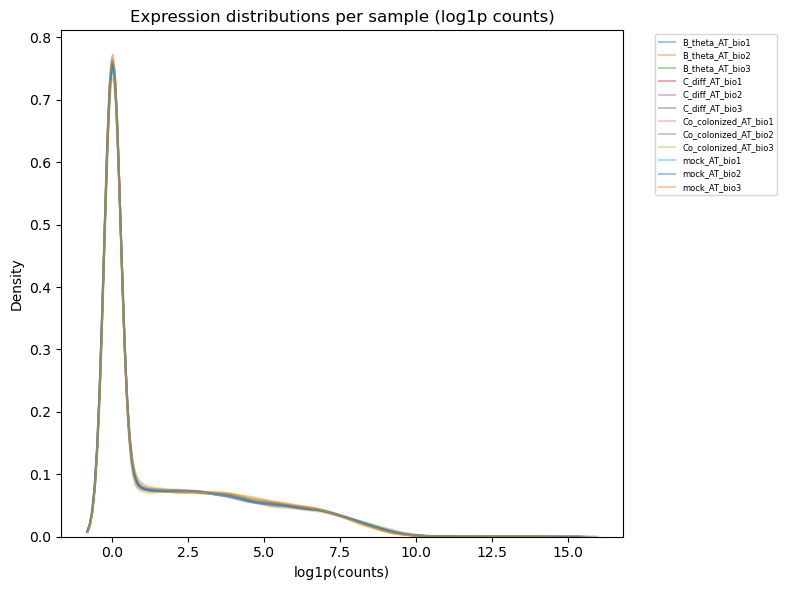

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use log1p counts for comparability
Xlog = np.asarray(adata.layers['log1p'])
sample_names = adata.obs_names

plt.figure(figsize=(8,6))
for i in range(Xlog.shape[0]):
    sns.kdeplot(Xlog[i,:], label=sample_names[i], alpha=0.4)

plt.title("Expression distributions per sample (log1p counts)")
plt.xlabel("log1p(counts)")
plt.ylabel("Density")
plt.legend(fontsize=6, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## PCA & Umap

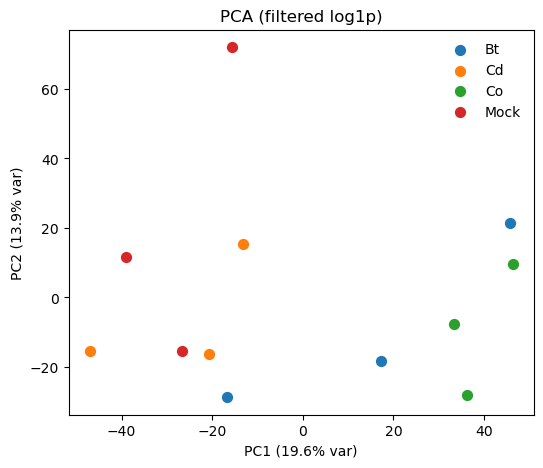

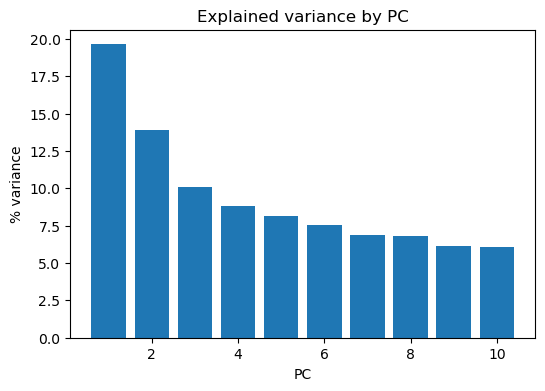

/home/job37yv/miniforge3/envs/scAnalysis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/job37yv/miniforge3/envs/scAnalysis/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


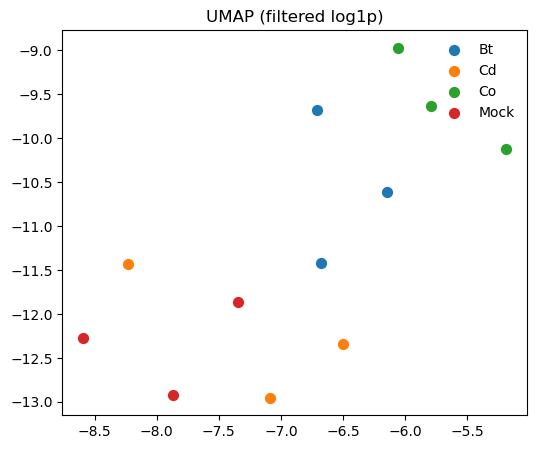

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

def run_pca_umap(A):
    X = np.asarray(A.layers['log1p'])  # samples × genes

    # PCA
    pca = PCA(n_components=min(10, A.n_obs-1), random_state=42)
    pcs = pca.fit_transform(X)
    ve = pca.explained_variance_ratio_

    plt.figure(figsize=(6,5))
    for cond in A.obs['condition'].unique():
        idx = A.obs['condition']==cond
        plt.scatter(pcs[idx,0], pcs[idx,1], label=cond, s=50)
    plt.xlabel(f"PC1 ({ve[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({ve[1]*100:.1f}% var)")
    plt.title("PCA (filtered log1p)")
    plt.legend(frameon=False)
    plt.show()

    # Variance explained
    plt.figure(figsize=(6,4))
    plt.bar(range(1,len(ve)+1), ve*100)
    plt.xlabel("PC")
    plt.ylabel("% variance")
    plt.title("Explained variance by PC")
    plt.show()

    # UMAP (or fallback t-SNE)
    try:
        import umap
        reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
        emb = reducer.fit_transform(X)
        method = "UMAP"
    except ImportError:
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=2, random_state=42)
        emb = reducer.fit_transform(X)
        method = "t-SNE"

    plt.figure(figsize=(6,5))
    for cond in A.obs['condition'].unique():
        idx = A.obs['condition']==cond
        plt.scatter(emb[idx,0], emb[idx,1], label=cond, s=50)
    plt.title(f"{method} (filtered log1p)")
    plt.legend(frameon=False)
    plt.show()

run_pca_umap(adata_qc)


## Extra QC plots: Library size vs genes detected & Correlation heatmap between samples

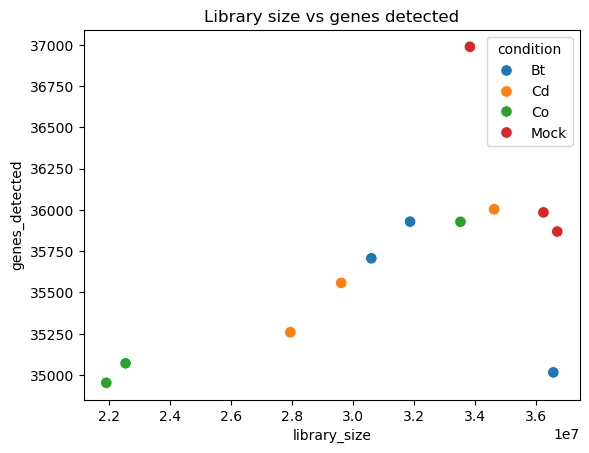

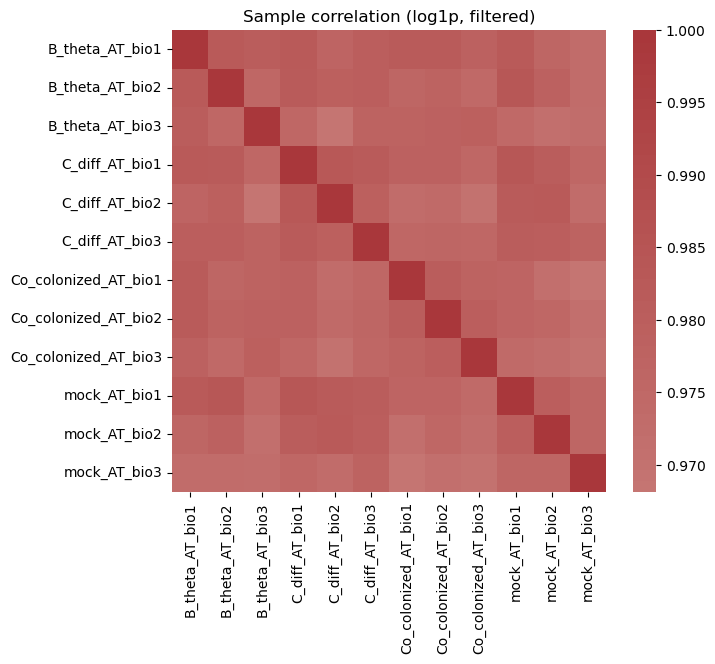

In [21]:
import seaborn as sns

qc_df = pd.DataFrame({
    "library_size": np.asarray(adata.layers['counts']).sum(axis=1),
    "genes_detected": (np.asarray(adata.layers['counts']) > 0).sum(axis=1),
    "condition": adata.obs['condition']
}, index=adata.obs_names)

sns.scatterplot(data=qc_df, x="library_size", y="genes_detected", hue="condition", s=70)
plt.title("Library size vs genes detected")
plt.show()

# Sample–sample correlation (Pearson, log1p)
Xlog = np.asarray(adata_qc.layers['log1p'])
corr = np.corrcoef(Xlog)
plt.figure(figsize=(7,6))
sns.heatmap(corr, xticklabels=adata_qc.obs_names, yticklabels=adata_qc.obs_names, cmap="vlag", center=0.9)
plt.title("Sample correlation (log1p, filtered)")
plt.show()


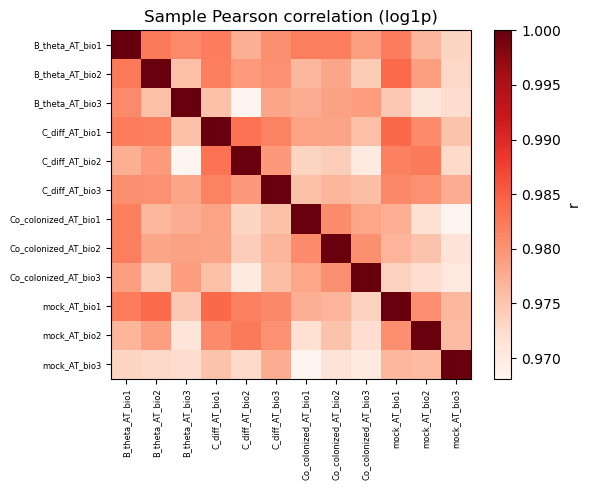

In [23]:
# Sample–sample correlation on log1p (use filtered data)
import matplotlib.pyplot as plt
import numpy as np

Xlog = np.asarray(adata_qc.layers['log1p'])
corr = np.corrcoef(Xlog)
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect='auto', cmap="Reds")
plt.xticks(range(adata_qc.n_obs), adata_qc.obs_names, rotation=90, fontsize=6)
plt.yticks(range(adata_qc.n_obs), adata_qc.obs_names, fontsize=6)
plt.title("Sample Pearson correlation (log1p)")
plt.colorbar(label="r")
plt.tight_layout()
plt.show()


# Export counts + metadata

In [26]:
import pandas as pd, numpy as np, pathlib as pl

out = pl.Path("/storage/users/job37yv/Projects/Franziska_faber/data/processed_data/qc_fractional_counts"); out.mkdir(exist_ok=True, parents=True)
# use all genes (or adata_qc.var_names if you want the filtered set)
X = pd.DataFrame(np.asarray(adata.layers["counts"]), index=adata.obs_names, columns=adata.var_names)
X.to_csv(out/"counts_fractional.tsv", sep="\t")
adata.obs.to_csv(out/"sample_metadata.tsv", sep="\t")
